In [2]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "/mnt/d/Prjs/EEG"

import os
subs = [d for d in os.listdir(DATA_PATH) if d.startswith("sub-") and os.path.isdir(os.path.join(DATA_PATH, d))]
subs[:10]

['sub-01',
 'sub-02',
 'sub-03',
 'sub-04',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-08',
 'sub-09',
 'sub-10']

In [4]:
sub = "sub-01"
sub_path = f"{DATA_PATH}/{sub}/eeg"

# File raw BrainVision (.vhdr)
raw_file = f"{sub_path}/{sub}_task-oddball_eeg.vhdr"

raw = mne.io.read_raw_brainvision(raw_file, preload=True)
raw

Extracting parameters from /mnt/d/Prjs/EEG/sub-01/eeg/sub-01_task-oddball_eeg.vhdr...


Setting channel info structure...
Reading 0 ... 1371319  =      0.000 ...  1371.319 secs...


<RawBrainVision | sub-01_task-oddball_eeg.eeg, 127 x 1371320 (1371.3 s), ~1.30 GiB, data loaded>

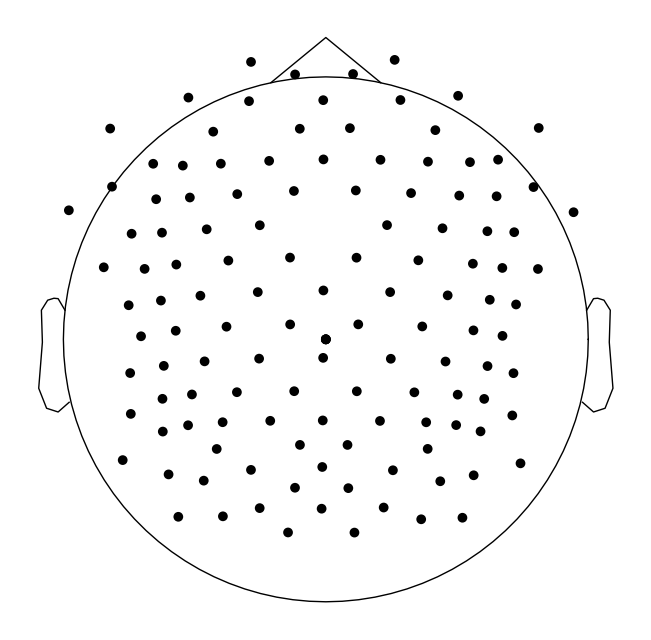

In [13]:
# Set standard 10-05 montage and plot sensor locations
montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage, on_missing='ignore')

fig = raw.plot_sensors(kind='topomap')

In [50]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"

start, stop = 0, 5000  # first 5 seconds
data, times = raw.get_data(picks='eeg', start=start, stop=stop, return_times=True)

df = pd.DataFrame(data.T, columns=raw.ch_names)
df['time'] = times
df_melt = df.melt(id_vars='time', var_name='channel', value_name='voltage')

fig = px.line(df_melt, x='time', y='voltage', color='channel')

# Interactive HTML
fig.write_html("raw_segment.html")

In [24]:
# Get events from annotations
events, event_dict = mne.events_from_annotations(raw)

events

Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 12'), np.str_('Time 0/')]


array([[      0,       0,   10001],
       [      0,       0,   99999],
       [  22265,       0,       5],
       ...,
       [1305789,       0,       5],
       [1307223,       0,       6],
       [1308856,       0,       5]], shape=(776, 3))

In [19]:
event_dict

{np.str_('New Segment/'): 99999,
 np.str_('Stimulus/S  1'): 1,
 np.str_('Stimulus/S  5'): 5,
 np.str_('Stimulus/S  6'): 6,
 np.str_('Stimulus/S  7'): 7,
 np.str_('Stimulus/S 10'): 10,
 np.str_('Stimulus/S 12'): 12,
 np.str_('Time 0/'): 10001}

In [25]:
codes = events[:, 2]  # Column 3 of array events → event codes
pd.Series(codes).value_counts() 

5        498
1        107
6         81
7         81
10         4
12         3
10001      1
99999      1
Name: count, dtype: int64

**Dataset overview:**  

The numbers above show the count of events (trials) for each event code in the oddball task:

- `5` (498 trials) → frequent stimulus (Standard stimulus, S5)  
- `7` (81 trials) → target stimulus (S6)  
- `6` (81 trials) → deviant stimulus (S7)  
- Other codes (`1, 10, 12, 10001, 99999`) correspond to responses, breaks, or segment markers and are not used for classification.  

The correspondence between event codes and stimulus types (S5/S6/S7) is reported in **Table 3 of the Nencki-Symfonia dataset paper**.  

This distribution shows that frequent trials are much more numerous than target trials, so balancing is needed before training a classifier.
